# Question 6

## 6.a
Import the data in Python and explore it a bit.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X_1     410 non-null    float64
 1   X_2     410 non-null    float64
 2   y       410 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 9.7 KB
None
               X_1          X_2           y
count   410.000000   410.000000  410.000000
mean   4895.705237  4973.234806    0.500000
std    2860.877356  3119.801712    0.500611
min      27.557777    29.069434    0.000000
25%    2341.140941  2124.504835    0.000000
50%    4987.225190  5701.130456    0.500000
75%    7303.607081  7762.583984    1.000000
max    9941.145899  9960.403013    1.000000


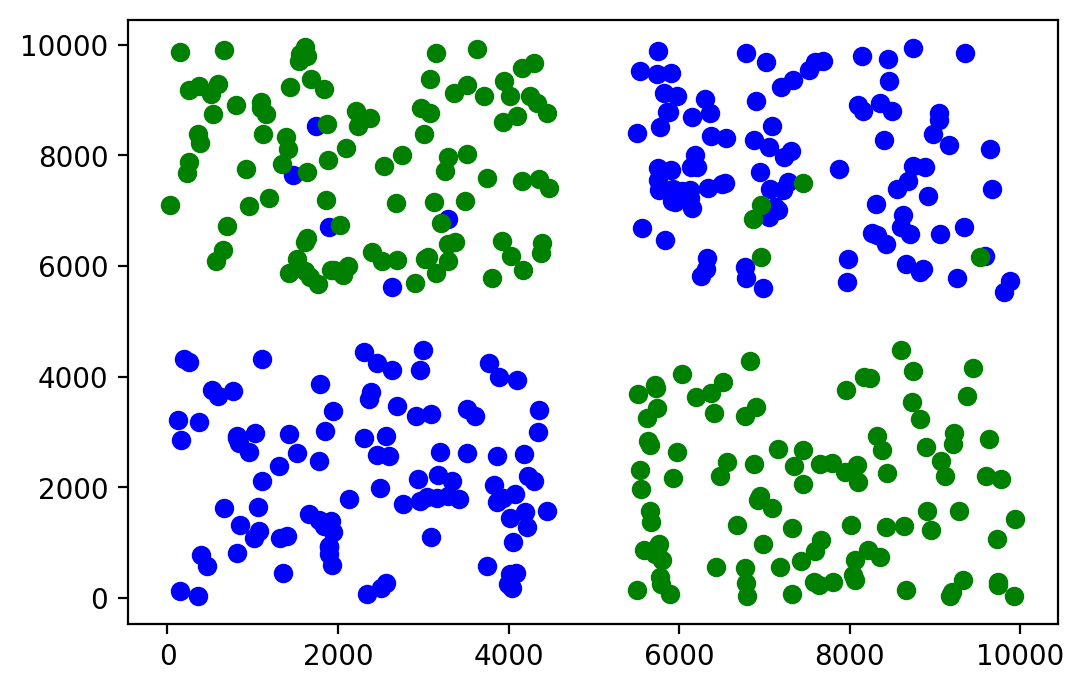

In [4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_data = pd.read_csv("train_data.csv")
validate_data = pd.read_csv("validate_data.csv")

# Explore the data
print(train_data.info())
print(train_data.describe())

# Plot the data
plt.figure(dpi=200)
y_train_0 = train_data[train_data['y']==0]
y_train_1 = train_data[train_data['y']==1]
plt.scatter(y_train_0['X_1'],y_train_0['X_2'],c='blue', label='y_0')
plt.scatter(y_train_1['X_1'],y_train_1['X_2'],c='green', label='y_1')

## 6.b
Perform data normalization

In [5]:

# Zero-mean-unit-variance: adjust the distribution of the feature
#                          to get normalization distribution
def zero_mean_unit_variance(X: np.array) -> np.array:
    """
    Zero-mean-unit-variance to adjust the distribution of the feature
     and get the normalization distribution
    """
    return np.array([[(val - np.mean(col))/np.std(col) for val in col] for col in X.T]).T

# min-max: to normalize the scale of different features 
#          and speed up the rate
def min_max_normalize(X: np.array) -> np.array:
    """
    Min max normalization to normalize the scale of different features
     and speed up the rate
    """
    return np.array([[(val - min(col))/(max(col) - min(col)) for val in col] for col in X.T]).T

x_train_array = pd.DataFrame(train_data,columns=['X_1','X_2']).to_numpy()
norm_zero = zero_mean_unit_variance(x_train_array)
norm_minmax = min_max_normalize(x_train_array)

norm1 = pd.DataFrame(norm_zero)
norm2 = pd.DataFrame(norm_minmax)

print("first 4 row after zero-mean-unit-var normalization:\n",norm1.head(4))
print("first 4 row after min-max normalization:\n",norm2.head(4))

first 4 row after zero-mean-unit-var normalization:
           0         1
0 -0.692414 -0.540345
1 -1.052279 -1.345223
2 -0.247493 -1.097164
3  1.137351  1.550334
first 4 row after min-max normalization:
           0         1
0  0.291484  0.328300
1  0.187760  0.075766
2  0.419723  0.153595
3  0.818876  0.984258


## 6.c 
input layer size: 410 rows* 2 columns
output layer size  : 2 rows*2columns


In [10]:
x_train = np.array(pd.DataFrame(train_data,columns=['X_1','X_2']))
y_train = np.array(pd.DataFrame(train_data,columns=['y']))
x_validate = np.array(pd.DataFrame(validate_data,columns=['X_1','X_2']))
y_validate = np.array(pd.DataFrame(validate_data,columns=['y']))
min_max_x_train = min_max_normalize(x_train)
min_max_x_validate = min_max_normalize(x_validate)

In [22]:
class MLP():
    """
    Class for multi-layer perceptron implementation
    """
    def __init__(self, 
                 X: np.array, Y: np.array, 
                 X_val: np.array, Y_val: np.array, 
                 L: int = 2, N_l: int = 10):
        # X = (1 X1 X2...Xd)
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        # Y = (0 1)
        self.Y = np.squeeze(np.eye(2)[Y.astype(np.int).reshape(-1)])
        # same reshape for X_validate
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        # same reshape for Y_validate
        self.Y_val = np.squeeze(np.eye(2)[Y_val.astype(np.int).reshape(-1)])
        
        # Hidden layer
        self.L = L
        # Neurons in each layer
        self.N_l = N_l
        
        self.n_samples = self.X.shape[0]
        self.layer_sizes =np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        
        # initialize weights
        self.__init_weights()
        
        # save accuracy and loss measures 
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.metrics = [self.train_loss, self.train_acc, self.val_loss, self.val_acc]
        
    def __sigmoid(self, x: np.array):
        """
        Sigmoid activation function
        """
        return 1./(1.+np.exp(-x))
    
    def __softmax(self, x: np.array):

        exp = np.exp(x - x.max())
        return exp / exp.sum(axis=1, keepdims=True)
    
    def __loss(self, y_pred: np.array, y: np.array):
        """
        cross-entropy
        """
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self, y_pred: np.array, y: np.array):  

        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self, h: callable):
        """
        Derivative of the sigmoid activation function where h=sigmoid(x)
        """
        return h*(1-h)
    
    def __to_categorical(self, x: np.array):  
        """
        Transform probabilities into categorical predictions row-wise, 
         by simply taking the max probability
        """
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        """
        Initialize the weights of the network given the sizes of the layers
        """
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights)
    
    def __init_layers(self, batch_size: int):
        """
        Initialize and allocate arrays for the hidden layer activations 
        """
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self, batch: np.array):
        """
        Perform a forward pass of `batch` samples (N_samples x N_features)
        """
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__sigmoid(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self, batch_y: np.array):
        """
        Update the weights of the network through back-propagation
        """
        delta_t = (self.__out - batch_y)*self.__sigmoid_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))#/self.batch_size
            delta_t = self.__sigmoid_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self, X: np.array):
        """
        Generate a categorical, one-hot, prediction given an input X
        """
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self, X: np.array, Y: np.array):
        """
        Evaluate the performance (accuracy) predicting on X with true labels Y
        """
        return self.__accuracy(self.predict(X), Y)
        
    def train(self, batch_size: int = 8, epochs: int = 25, lr: float = 1.0):
        """
        Train the model
        """
        
        self.lr = lr
        self.batch_size=batch_size
        
        for epoch in range(epochs):
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
        
            # min max batch
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} ")
            
#             if round(val_acc, 3) == 0.976:
#                 print("Reached maximum accuracy. Stopping to reduce computational expense.")
#                 break

In [32]:
model = MLP(min_max_x_train,y_train,min_max_x_validate,y_validate,L=2,N_l=10)
# 17;30;0.5 -> 18；27；0.5 ->19;27;0.5
model.train(batch_size=50,epochs=1500,lr=0.01)

C:\Users\74045\AppData\Local\Temp/ipykernel_6728/986360109.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.Y = np.squeeze(np.eye(2)[Y.astype(np.int).reshape(-1)])
C:\Users\74045\AppData\Local\Temp/ipykernel_6728/986360109.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

Epoch 1: loss = 0.705 | acc = 0.499 | val_loss = 0.701 | val_acc = 0.5 
Epoch 2: loss = 0.7 | acc = 0.5 | val_loss = 0.697 | val_acc = 0.5 
Epoch 3: loss = 0.697 | acc = 0.5 | val_loss = 0.695 | val_acc = 0.5 
Epoch 4: loss = 0.695 | acc = 0.5 | val_loss = 0.694 | val_acc = 0.5 
Epoch 5: loss = 0.694 | acc = 0.5 | val_loss = 0.694 | val_acc = 0.5 
Epoch 6: loss = 0.694 | acc = 0.5 | val_loss = 0.693 | val_acc = 0.5 
Epoch 7: loss = 0.694 | acc = 0.5 | val_loss = 0.693 | val_acc = 0.5 
Epoch 8: loss = 0.694 | acc = 0.5 | val_loss = 0.693 | val_acc = 0.5 
Epoch 9: loss = 0.693 | acc = 0.5 | val_loss = 0.693 | val_acc = 0.5 
Epoch 10: loss = 0.693 | acc = 0.481 | val_loss = 0.693 | val_acc = 0.5 
Epoch 11: loss = 0.693 | acc = 0.5 | val_loss = 0.693 | val_acc = 0.5 
Epoch 12: loss = 0.694 | acc = 0.441 | val_loss = 0.693 | val_acc = 0.5 
Epoch 13: loss = 0.693 | acc = 0.498 | val_loss = 0.693 | val_acc = 0.488 
Epoch 14: loss = 0.694 | acc = 0.459 | val_loss = 0.693 | val_acc = 0.5 
Epoch

Epoch 123: loss = 0.693 | acc = 0.485 | val_loss = 0.693 | val_acc = 0.598 
Epoch 124: loss = 0.693 | acc = 0.507 | val_loss = 0.693 | val_acc = 0.573 
Epoch 125: loss = 0.693 | acc = 0.502 | val_loss = 0.693 | val_acc = 0.488 
Epoch 126: loss = 0.693 | acc = 0.498 | val_loss = 0.693 | val_acc = 0.476 
Epoch 127: loss = 0.693 | acc = 0.493 | val_loss = 0.693 | val_acc = 0.415 
Epoch 128: loss = 0.693 | acc = 0.468 | val_loss = 0.693 | val_acc = 0.451 
Epoch 129: loss = 0.694 | acc = 0.505 | val_loss = 0.693 | val_acc = 0.402 
Epoch 130: loss = 0.693 | acc = 0.476 | val_loss = 0.693 | val_acc = 0.402 
Epoch 131: loss = 0.693 | acc = 0.486 | val_loss = 0.693 | val_acc = 0.488 
Epoch 132: loss = 0.693 | acc = 0.471 | val_loss = 0.693 | val_acc = 0.488 
Epoch 133: loss = 0.693 | acc = 0.512 | val_loss = 0.693 | val_acc = 0.402 
Epoch 134: loss = 0.693 | acc = 0.456 | val_loss = 0.693 | val_acc = 0.402 
Epoch 135: loss = 0.693 | acc = 0.466 | val_loss = 0.693 | val_acc = 0.402 
Epoch 136: l

Epoch 263: loss = 0.693 | acc = 0.545 | val_loss = 0.692 | val_acc = 0.378 
Epoch 264: loss = 0.693 | acc = 0.493 | val_loss = 0.692 | val_acc = 0.378 
Epoch 265: loss = 0.693 | acc = 0.517 | val_loss = 0.692 | val_acc = 0.366 
Epoch 266: loss = 0.693 | acc = 0.439 | val_loss = 0.692 | val_acc = 0.585 
Epoch 267: loss = 0.693 | acc = 0.478 | val_loss = 0.692 | val_acc = 0.573 
Epoch 268: loss = 0.693 | acc = 0.392 | val_loss = 0.692 | val_acc = 0.634 
Epoch 269: loss = 0.692 | acc = 0.48 | val_loss = 0.692 | val_acc = 0.646 
Epoch 270: loss = 0.693 | acc = 0.629 | val_loss = 0.692 | val_acc = 0.537 
Epoch 271: loss = 0.693 | acc = 0.478 | val_loss = 0.692 | val_acc = 0.598 
Epoch 272: loss = 0.693 | acc = 0.622 | val_loss = 0.692 | val_acc = 0.463 
Epoch 273: loss = 0.692 | acc = 0.593 | val_loss = 0.692 | val_acc = 0.427 
Epoch 274: loss = 0.692 | acc = 0.622 | val_loss = 0.692 | val_acc = 0.354 
Epoch 275: loss = 0.693 | acc = 0.488 | val_loss = 0.692 | val_acc = 0.402 
Epoch 276: lo

Epoch 399: loss = 0.691 | acc = 0.617 | val_loss = 0.691 | val_acc = 0.549 
Epoch 400: loss = 0.691 | acc = 0.471 | val_loss = 0.691 | val_acc = 0.585 
Epoch 401: loss = 0.691 | acc = 0.668 | val_loss = 0.691 | val_acc = 0.476 
Epoch 402: loss = 0.69 | acc = 0.541 | val_loss = 0.691 | val_acc = 0.488 
Epoch 403: loss = 0.691 | acc = 0.539 | val_loss = 0.691 | val_acc = 0.476 
Epoch 404: loss = 0.691 | acc = 0.573 | val_loss = 0.69 | val_acc = 0.463 
Epoch 405: loss = 0.691 | acc = 0.559 | val_loss = 0.69 | val_acc = 0.463 
Epoch 406: loss = 0.691 | acc = 0.429 | val_loss = 0.69 | val_acc = 0.61 
Epoch 407: loss = 0.691 | acc = 0.627 | val_loss = 0.69 | val_acc = 0.549 
Epoch 408: loss = 0.691 | acc = 0.598 | val_loss = 0.69 | val_acc = 0.549 
Epoch 409: loss = 0.691 | acc = 0.507 | val_loss = 0.69 | val_acc = 0.573 
Epoch 410: loss = 0.691 | acc = 0.656 | val_loss = 0.69 | val_acc = 0.463 
Epoch 411: loss = 0.69 | acc = 0.531 | val_loss = 0.69 | val_acc = 0.476 
Epoch 412: loss = 0.69 

Epoch 533: loss = 0.68 | acc = 0.668 | val_loss = 0.679 | val_acc = 0.671 
Epoch 534: loss = 0.68 | acc = 0.673 | val_loss = 0.679 | val_acc = 0.646 
Epoch 535: loss = 0.68 | acc = 0.636 | val_loss = 0.679 | val_acc = 0.646 
Epoch 536: loss = 0.679 | acc = 0.656 | val_loss = 0.679 | val_acc = 0.646 
Epoch 537: loss = 0.68 | acc = 0.649 | val_loss = 0.678 | val_acc = 0.646 
Epoch 538: loss = 0.679 | acc = 0.6 | val_loss = 0.678 | val_acc = 0.695 
Epoch 539: loss = 0.679 | acc = 0.641 | val_loss = 0.678 | val_acc = 0.695 
Epoch 540: loss = 0.679 | acc = 0.597 | val_loss = 0.678 | val_acc = 0.695 
Epoch 541: loss = 0.679 | acc = 0.619 | val_loss = 0.678 | val_acc = 0.695 
Epoch 542: loss = 0.679 | acc = 0.654 | val_loss = 0.677 | val_acc = 0.695 
Epoch 543: loss = 0.678 | acc = 0.656 | val_loss = 0.677 | val_acc = 0.695 
Epoch 544: loss = 0.678 | acc = 0.661 | val_loss = 0.677 | val_acc = 0.695 
Epoch 545: loss = 0.678 | acc = 0.683 | val_loss = 0.677 | val_acc = 0.695 
Epoch 546: loss = 

Epoch 668: loss = 0.589 | acc = 0.803 | val_loss = 0.583 | val_acc = 0.854 
Epoch 669: loss = 0.587 | acc = 0.807 | val_loss = 0.581 | val_acc = 0.817 
Epoch 670: loss = 0.585 | acc = 0.81 | val_loss = 0.578 | val_acc = 0.866 
Epoch 671: loss = 0.583 | acc = 0.829 | val_loss = 0.576 | val_acc = 0.89 
Epoch 672: loss = 0.581 | acc = 0.822 | val_loss = 0.575 | val_acc = 0.927 
Epoch 673: loss = 0.579 | acc = 0.858 | val_loss = 0.572 | val_acc = 0.927 
Epoch 674: loss = 0.576 | acc = 0.873 | val_loss = 0.569 | val_acc = 0.915 
Epoch 675: loss = 0.575 | acc = 0.863 | val_loss = 0.568 | val_acc = 0.939 
Epoch 676: loss = 0.571 | acc = 0.88 | val_loss = 0.566 | val_acc = 0.939 
Epoch 677: loss = 0.57 | acc = 0.883 | val_loss = 0.562 | val_acc = 0.927 
Epoch 678: loss = 0.567 | acc = 0.903 | val_loss = 0.56 | val_acc = 0.927 
Epoch 679: loss = 0.564 | acc = 0.91 | val_loss = 0.557 | val_acc = 0.927 
Epoch 680: loss = 0.562 | acc = 0.91 | val_loss = 0.555 | val_acc = 0.927 
Epoch 681: loss = 0

Epoch 797: loss = 0.386 | acc = 0.976 | val_loss = 0.385 | val_acc = 0.976 
Epoch 798: loss = 0.386 | acc = 0.973 | val_loss = 0.387 | val_acc = 0.976 
Epoch 799: loss = 0.385 | acc = 0.976 | val_loss = 0.384 | val_acc = 0.976 
Epoch 800: loss = 0.384 | acc = 0.976 | val_loss = 0.386 | val_acc = 0.976 
Epoch 801: loss = 0.384 | acc = 0.976 | val_loss = 0.385 | val_acc = 0.976 
Epoch 802: loss = 0.384 | acc = 0.976 | val_loss = 0.383 | val_acc = 0.976 
Epoch 803: loss = 0.383 | acc = 0.976 | val_loss = 0.383 | val_acc = 0.976 
Epoch 804: loss = 0.383 | acc = 0.976 | val_loss = 0.383 | val_acc = 0.976 
Epoch 805: loss = 0.382 | acc = 0.976 | val_loss = 0.384 | val_acc = 0.976 
Epoch 806: loss = 0.381 | acc = 0.973 | val_loss = 0.385 | val_acc = 0.976 
Epoch 807: loss = 0.382 | acc = 0.976 | val_loss = 0.382 | val_acc = 0.976 
Epoch 808: loss = 0.381 | acc = 0.976 | val_loss = 0.381 | val_acc = 0.976 
Epoch 809: loss = 0.38 | acc = 0.976 | val_loss = 0.382 | val_acc = 0.976 
Epoch 810: lo

Epoch 908: loss = 0.359 | acc = 0.976 | val_loss = 0.361 | val_acc = 0.976 
Epoch 909: loss = 0.359 | acc = 0.976 | val_loss = 0.363 | val_acc = 0.976 
Epoch 910: loss = 0.359 | acc = 0.976 | val_loss = 0.362 | val_acc = 0.976 
Epoch 911: loss = 0.359 | acc = 0.976 | val_loss = 0.362 | val_acc = 0.976 
Epoch 912: loss = 0.359 | acc = 0.976 | val_loss = 0.362 | val_acc = 0.976 
Epoch 913: loss = 0.359 | acc = 0.976 | val_loss = 0.363 | val_acc = 0.976 
Epoch 914: loss = 0.358 | acc = 0.976 | val_loss = 0.361 | val_acc = 0.976 
Epoch 915: loss = 0.358 | acc = 0.976 | val_loss = 0.361 | val_acc = 0.976 
Epoch 916: loss = 0.359 | acc = 0.976 | val_loss = 0.361 | val_acc = 0.976 
Epoch 917: loss = 0.358 | acc = 0.976 | val_loss = 0.362 | val_acc = 0.976 
Epoch 918: loss = 0.358 | acc = 0.976 | val_loss = 0.36 | val_acc = 0.976 
Epoch 919: loss = 0.358 | acc = 0.976 | val_loss = 0.36 | val_acc = 0.976 
Epoch 920: loss = 0.358 | acc = 0.976 | val_loss = 0.361 | val_acc = 0.976 
Epoch 921: los

Epoch 1022: loss = 0.35 | acc = 0.976 | val_loss = 0.354 | val_acc = 0.976 
Epoch 1023: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1024: loss = 0.35 | acc = 0.976 | val_loss = 0.354 | val_acc = 0.976 
Epoch 1025: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1026: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1027: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1028: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1029: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1030: loss = 0.35 | acc = 0.976 | val_loss = 0.352 | val_acc = 0.976 
Epoch 1031: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1032: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1033: loss = 0.35 | acc = 0.976 | val_loss = 0.353 | val_acc = 0.976 
Epoch 1034: loss = 0.35 | acc = 0.976 | val_loss = 0.352 | val_acc = 0.976 
Epoch 1035: 

Epoch 1162: loss = 0.346 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1163: loss = 0.346 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1164: loss = 0.346 | acc = 0.976 | val_loss = 0.349 | val_acc = 0.976 
Epoch 1165: loss = 0.346 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1166: loss = 0.345 | acc = 0.976 | val_loss = 0.349 | val_acc = 0.976 
Epoch 1167: loss = 0.346 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1168: loss = 0.346 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1169: loss = 0.346 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1170: loss = 0.345 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1171: loss = 0.345 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1172: loss = 0.345 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 
Epoch 1173: loss = 0.345 | acc = 0.976 | val_loss = 0.349 | val_acc = 0.976 
Epoch 1174: loss = 0.345 | acc = 0.976 | val_loss = 0.348 | val_acc = 0.976 

Epoch 1299: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1300: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1301: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1302: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1303: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1304: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1305: loss = 0.343 | acc = 0.975 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1306: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1307: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1308: loss = 0.343 | acc = 0.975 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1309: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1310: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 
Epoch 1311: loss = 0.343 | acc = 0.976 | val_loss = 0.346 | val_acc = 0.976 

Epoch 1425: loss = 0.342 | acc = 0.976 | val_loss = 0.344 | val_acc = 0.976 
Epoch 1426: loss = 0.342 | acc = 0.976 | val_loss = 0.344 | val_acc = 0.976 
Epoch 1427: loss = 0.342 | acc = 0.976 | val_loss = 0.345 | val_acc = 0.976 
Epoch 1428: loss = 0.342 | acc = 0.976 | val_loss = 0.344 | val_acc = 0.976 
Epoch 1429: loss = 0.342 | acc = 0.976 | val_loss = 0.345 | val_acc = 0.976 
Epoch 1430: loss = 0.342 | acc = 0.976 | val_loss = 0.344 | val_acc = 0.976 
Epoch 1431: loss = 0.342 | acc = 0.976 | val_loss = 0.345 | val_acc = 0.976 
Epoch 1432: loss = 0.342 | acc = 0.976 | val_loss = 0.344 | val_acc = 0.976 
Epoch 1433: loss = 0.342 | acc = 0.976 | val_loss = 0.344 | val_acc = 0.976 
Epoch 1434: loss = 0.342 | acc = 0.976 | val_loss = 0.344 | val_acc = 0.976 
Epoch 1435: loss = 0.342 | acc = 0.976 | val_loss = 0.344 | val_acc = 0.976 
Epoch 1436: loss = 0.342 | acc = 0.976 | val_loss = 0.345 | val_acc = 0.976 
Epoch 1437: loss = 0.342 | acc = 0.976 | val_loss = 0.345 | val_acc = 0.976 

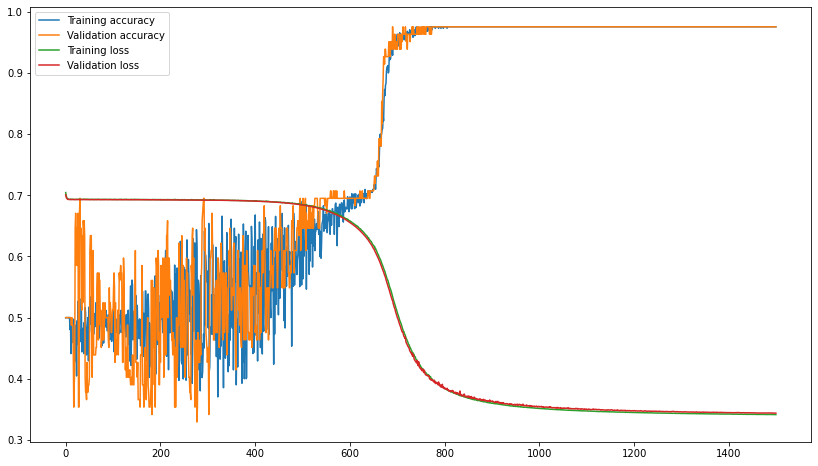

In [33]:
# (h) Plot the loss computed over the training set and over the validation set
plt.figure(figsize=(14,8))
plt.plot([i for i in range(len(model.train_acc))], model.train_acc, label="Training accuracy")
plt.plot([i for i in range(len(model.val_acc))], model.val_acc, label="Validation accuracy")
plt.plot([i for i in range(len(model.train_loss))], model.train_loss, label="Training loss")
plt.plot([i for i in range(len(model.val_loss))], model.val_loss, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
def generate_confusion_matrix(y_true: list, y_pred: list):

    y_pred_new = [0 if x[0] == 1. else 1 for x in y_pred]
    y_true_new = [0 if x[0] == 1. else 1 for x in y_true]
    
    confusion_matrix = [[0, 0], [0, 0]]
    for y_t_i, y_p_i in zip(y_true_new, y_pred_new):
        if y_t_i == 0 and y_p_i == 0:
            confusion_matrix[0][0] += 1
        elif y_t_i == 1 and y_p_i == 1:
            confusion_matrix[1][1] += 1
        elif y_t_i == 0 and y_p_i == 1:
            confusion_matrix[0][1] += 1
        elif y_t_i == 1 and y_p_i == 0:
            confusion_matrix[1][0] += 1

    return confusion_matrix